# Classification

In this tutorial, we will build a classification model for a two-color FRET dataset. The dataset has been manually labeled with a binary label indicating whether the trace should be included for next step analysis. 

We will:
  - Train a classification model using META-SiM embeddings.
  - Evaluate the model using a test dataset.

In [1]:
import openfret
import metasim
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics

# Load data

Here, we use dataset from the paper: 

Widom, J. R. et al. Ligand Modulates Cross-Coupling between Riboswitch Folding and Transcriptional
Pausing. Mol. Cell 72, 541-552.e6 (2018). 

We have converted the dataset into a train set and a test set, both in the OpenFRET format. For details on OpenFRET data format, please visit this [link](https://github.com/simol-lab/OpenFRET)

In [2]:
train_data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_3_train.json'),
)
test_data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_3_test.json'),
)

To inspect the traces, the plot traces from each label class in the training dataset.

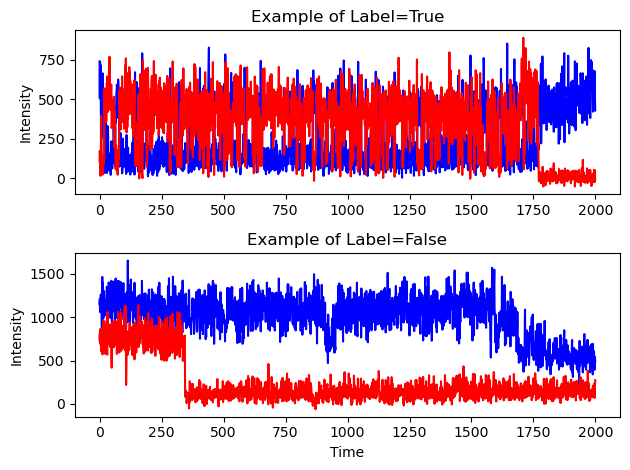

In [3]:
fig, axes = plt.subplots(2)
for trace in train_data.traces:
    if trace.metadata['manual_label'] == True:
        for channel in trace.channels:
            if channel.channel_type == 'donor':
                color = 'b'
            elif channel.channel_type == 'acceptor':
                color = 'r'
            axes[0].plot(channel.data, color=color)
            axes[0].set_ylabel('Intensity')
            axes[0].set_title('Example of Label=True')
        break
for trace in train_data.traces:
    if trace.metadata['manual_label'] == False:
        for channel in trace.channels:
            if channel.channel_type == 'donor':
                color = 'b'
            elif channel.channel_type == 'acceptor':
                color = 'r'
            axes[1].plot(channel.data, color=color)
            axes[1].set_ylabel('Intensity')
            axes[1].set_xlabel('Time')
            axes[1].set_title('Example of Label=False')
        break
plt.tight_layout()

# Classification Model

Here we use META-SiM's built-in function to train a logistic regression model for this problem, based on the embeddings generated by META-SiM.

In [4]:
model = metasim.fret.Model()
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding = model(train_data)

  0%|          | 0/2353 [00:00<?, ?it/s]

In [5]:
label = np.array([trace.metadata['manual_label'] for trace in train_data.traces])

In [6]:
task_model = metasim.fret.tuning.train_classification(
    embedding,
    label,
)

Let's examin the training accuracy and ROC curve.

In [7]:
prob = task_model.predict_proba(embedding)
pred = task_model.predict(embedding)

In [8]:
print('Training accuracy is', np.mean(pred == label))

Training accuracy is 0.9864003399915002


Text(0.5, 1.0, 'Training ROC Curve')

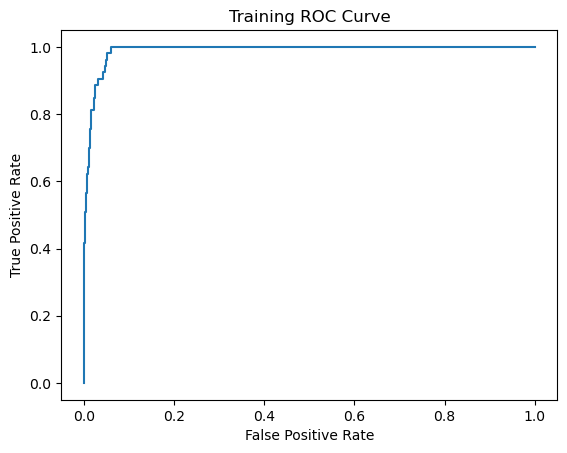

In [9]:
fpr, tpr, thresholds = metrics.roc_curve(label, prob[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curve')

# Evaluation on test data

We can use test data collected from different experimental trials to test the performance of the classification model. 

It's recommended to use data from different experiment trials for testing because in practice the model will be used on new experimental data.

In [10]:
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding_test = model(test_data)
label_test = np.array([trace.metadata['manual_label'] for trace in test_data.traces])

  0%|          | 0/12492 [00:00<?, ?it/s]

In [11]:
prob_test = task_model.predict_proba(embedding_test)
pred_test = task_model.predict(embedding_test)

In [12]:
print('Test accuracy is', np.mean(pred_test == label_test))

Test accuracy is 0.9771853986551393


Text(0.5, 1.0, 'Test ROC Curve')

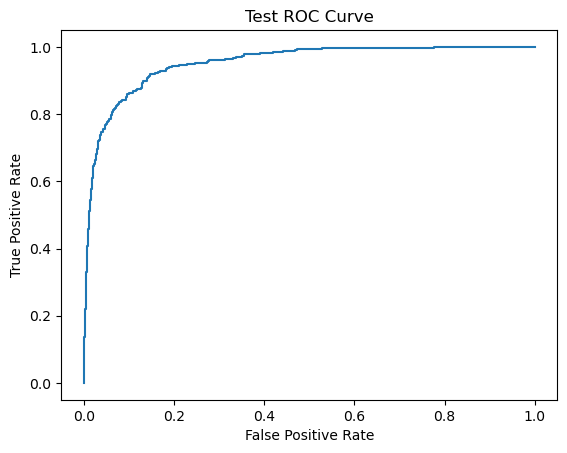

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(label_test, prob_test[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')

# Save and load model

Now that we have a trained and validated the model, we will save it to re-use it in the future. Models can be easily saved and read with buit-in functions.

In [14]:
task_model.save_to_json('/tmp/saved_model.json')

In [15]:
loaded_model = metasim.fret.tuning.ModelConfig.load_from_json(
    '/tmp/saved_model.json',
)

# Framewise Classification

For some advanced use cases such as trace segmentation or idealization, a framewise classification is needed. Here, we will use an example of trace segmentation, i.e. selecting the region of interest per trace, as an example to show how to perform framewise classification with META-SiM. 

The dataset is from the same paper:
Widom, J. R. et al. Ligand Modulates Cross-Coupling between Riboswitch Folding and Transcriptional Pausing. Mol. Cell 72, 541-552.e6 (2018).

The manual labels are region of interest per trace.

In [16]:
train_data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_3_framelevel_train.json'),
)
test_data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_3_framelevel_test.json'),
)

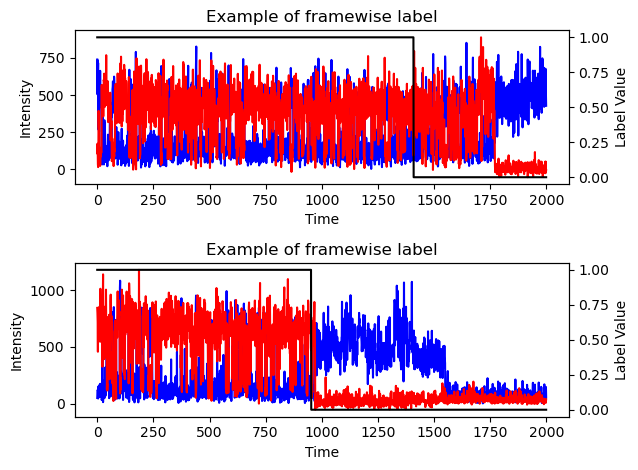

In [17]:
fig, axes = plt.subplots(2)
count = 0
for trace in train_data.traces:
    for channel in trace.channels:
        if channel.channel_type == 'donor':
            color = 'b'
        elif channel.channel_type == 'acceptor':
            color = 'r'
        axes[count].plot(channel.data, color=color)
        axes[count].set_ylabel('Intensity')
        axes[count].set_xlabel('Time')
        axes[count].set_title('Example of framewise label')
    ax2 = axes[count].twinx()  # instantiate a second Axes that shares the same x-axis
    ax2.plot(np.array(trace.metadata['manual_label']), color='k')
    ax2.set_ylabel('Label Value')
    count += 1
    if count == 2:
        break
plt.tight_layout()

In [18]:
model = metasim.fret.Model()
with tf.device('/CPU:0'):
    embedding = model.encode_frames(train_data)
#concatenate all framewise embeddings for training
embedding = np.concatenate(embedding, axis=0)

  0%|          | 0/53 [00:00<?, ?it/s]

In [19]:
label = np.concatenate([trace.metadata['manual_label'] for trace in train_data.traces], axis=0)
task_model = metasim.fret.tuning.train_classification(
    embedding,
    label,
)

In [20]:
prob = task_model.predict_proba(embedding)
pred = task_model.predict(embedding)

In [21]:
print('Training accuracy is', np.mean(pred == label))

Training accuracy is 0.9410283018867924


Text(0.5, 1.0, 'Framelevel Training ROC Curve')

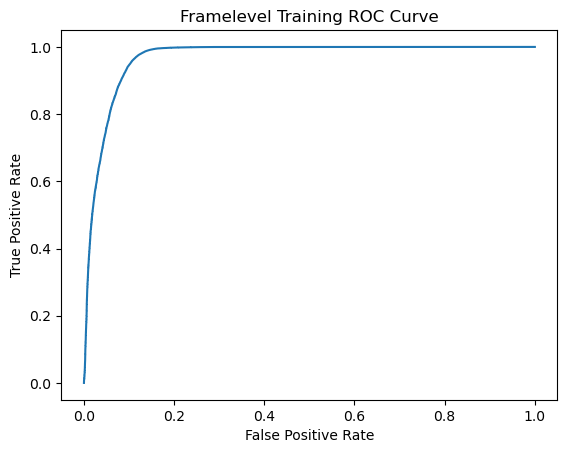

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(label, prob[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Framelevel Training ROC Curve')

In [23]:
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding_test = model(test_data)
embedding_test = np.concatenate(embedding_test)
label_test = np.concatenate([trace.metadata['manual_label'] for trace in test_data.traces])

  0%|          | 0/313 [00:00<?, ?it/s]

In [24]:
prob_test = task_model.predict_proba(embedding_test)
pred_test = task_model.predict(embedding_test)

In [25]:
print('Test accuracy is', np.mean(pred_test == label_test))

Test accuracy is 0.9030047923322684


Text(0.5, 1.0, 'Framewise Test ROC Curve')

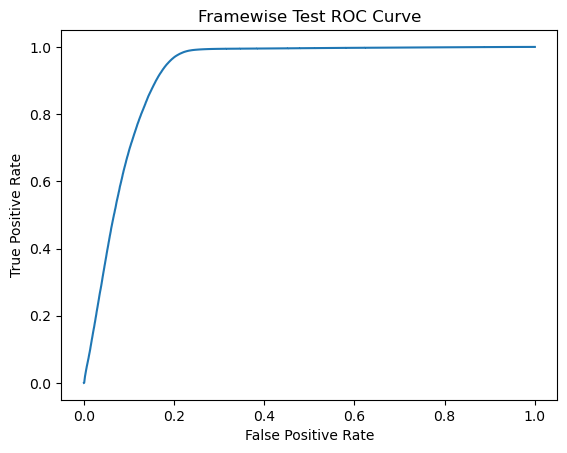

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(label_test, prob_test[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Framewise Test ROC Curve')

Below we plot the examples of predicted labels and the ground truth label on the test dataset. 

- The predicted label tends to follow the overall trend of ground truth.
- However, the predicted label can fluctuate heavily in some regions.
- It's recommended to add some low-pass filtering to smooth the predicted label.

  0%|          | 0/313 [00:00<?, ?it/s]

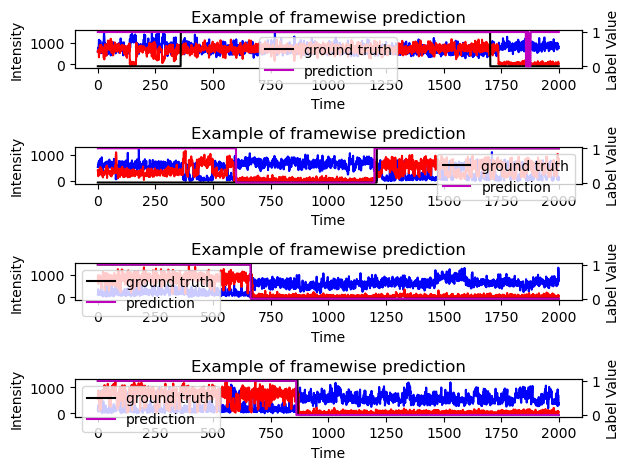

In [27]:
fig, axes = plt.subplots(4)
count = 0
with tf.device('/CPU:0'):
    embedding = model(test_data)
for trace, v in zip(test_data.traces, embedding):
    for channel in trace.channels:
        if channel.channel_type == 'donor':
            color = 'b'
        elif channel.channel_type == 'acceptor':
            color = 'r'
        axes[count].plot(channel.data, color=color)
        axes[count].set_ylabel('Intensity')
        axes[count].set_xlabel('Time')
        axes[count].set_title('Example of framewise prediction')
    ax2 = axes[count].twinx()  # instantiate a second Axes that shares the same x-axis
    ax2.plot(np.array(trace.metadata['manual_label']), color='k', label='ground truth')
    ax2.plot(
        metasim.fret.tuning.moving_majority_vote(
            task_model.predict(v), 51,
        ), color='m', label='prediction')
    ax2.set_ylabel('Label Value')
    ax2.legend()
    count += 1
    if count == len(axes):
        break
plt.tight_layout()